# Comparison between observations and sea level projections

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/dewilebars/Projects/Project_SeaLevelBudgets/Notebooks/')
import SeaLevelContrib as slc
import statsmodels.api as sm
import importlib

# displaying things
from ipywidgets import Image
import IPython.display

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

/Users/dewilebars/anaconda3/envs/p37ds/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
importlib.reload(slc)

<module 'SeaLevelContrib' from '/Users/dewilebars/Projects/Project_SeaLevelBudgets/Notebooks/SeaLevelContrib.py'>

In [3]:
# Report path to save figures in:
path_report = '../reports/CompObsProj/Figures/'
path_slb = '/Users/dewilebars/Projects/Project_SeaLevelBudgets/outputs/'

In [4]:
# Read the AR5 type local projections
KNMI14_45_ds = xr.open_dataset('../outputs/SeaLevelPDF_KNMI14_rcp45.nc')
KNMI14_85_ds = xr.open_dataset('../outputs/SeaLevelPDF_KNMI14_rcp85.nc')
KNMI14_45_ds

<xarray.Dataset>
Dimensions:      (bin: 52001, percentiles: 7, proc: 11, time: 95)
Coordinates:
  * time         (time) int64 2006 2007 2008 2009 2010 ... 2097 2098 2099 2100
  * proc         (proc) object 'Global steric' 'Local ocean' ... 'Total'
  * bin          (bin) float64 -20.0 -19.99 -19.98 -19.97 ... 500.0 500.0 500.0
  * percentiles  (percentiles) int64 1 5 17 50 83 95 99
Data variables:
    MAT_RES      (time, proc, bin) float64 ...
    Perc_ts      (time, proc, percentiles) float64 ...
Attributes:
    options:        Computations were done with the following options:: Local...
    source_file:    This NetCDF file was built from the Probabilistic Sea Lev...
    creation_date:  2020-03-27 15:21

In [5]:
# Read KNMI'14 projections
path_KNMI14 = '/Users/dewilebars/Projects/Project_ProbSLR/KNMI14/'
KNMI14_df = pd.read_csv(path_KNMI14 + 'K14_scenarios_by_year.csv')
del(KNMI14_df['year.1'])
KNMI14_df = KNMI14_df.set_index('year')

# Add subidence
subsidence = np.arange(KNMI14_df.shape[0]) * 0.045

for i in KNMI14_df.columns:
    KNMI14_df[i + '_sub'] = KNMI14_df[i] + subsidence

KNMI14_df[:10]

,low_05,low_95,high_05,high_95,low_05_sub,low_95_sub,high_05_sub,high_95_sub
year,,,,,,,,
1995,-0.2826,0.3990,-0.2826,0.3990,-0.2826,0.3990,-0.2826,0.3990
1996,0.1787,0.7226,0.1814,0.7251,0.2237,0.7676,0.2264,0.7701
1997,0.3832,1.3960,0.5654,1.5800,0.4732,1.4860,0.6554,1.6700
1998,0.5978,1.6610,0.9111,1.9760,0.7328,1.7960,1.0461,2.1110
1999,0.6499,2.0520,1.2050,2.6090,0.8299,2.2320,1.3850,2.7890
2000,0.7580,2.6900,1.5490,3.4850,0.9830,2.9150,1.7740,3.7100
2001,0.8874,3.1510,1.6750,3.9430,1.1574,3.4210,1.9450,4.2130
2002,1.0880,3.6320,1.8020,4.3510,1.4030,3.9470,2.1170,4.6660
2003,1.3860,4.0530,2.0380,4.7080,1.7460,4.4130,2.3980,5.0680


In [6]:
tg_id = [20, 22, 23, 24, 25, 32]
tg_df = slc.tide_gauge_obs(tg_id, interp=True)
tg_df.iloc[-10:]


,20,22,23,24,25,32,Average
time,,,,,,,
2009,12.172611,14.848387,8.513636,10.288312,7.905195,9.902721,10.605144
2010,12.372611,15.748387,7.213636,8.888312,5.705195,8.702721,9.771810
2011,12.772611,16.348387,11.913636,14.388312,12.305195,11.802721,13.255144
2012,12.072611,16.348387,10.413636,12.788312,11.005195,11.202721,12.305144
2013,10.672611,14.748387,7.513636,10.388312,6.705195,8.802721,9.805144
2014,14.472611,17.848387,10.813636,14.788312,12.005195,13.502721,13.905144
2015,14.772611,18.648387,13.813636,20.088312,16.705195,14.902721,16.488477
2016,15.072611,18.848387,11.913636,16.588312,13.005195,14.202721,14.938477
2017,16.672611,21.048387,15.813636,22.388312,17.605195,17.202721,18.455144


In [7]:
# Compute the linear trend from the tide gauge observations
def print_lin_trend(tg_df, start_y, end_y):
    lin_trend = np.polyfit(np.arange(start_y,end_y+1), 
                           tg_df.loc[start_y:end_y], 1)[0,:]
    print('Linear trend for period '+str(start_y)+'-'+str(end_y))
    print(lin_trend)

print_lin_trend(tg_df, 1993, 2016)
print_lin_trend(tg_df, 1993, 2017)
print_lin_trend(tg_df, 1993, 2018)

Linear trend for period 1993-2016
[0.30530435 0.245      0.17369565 0.27634783 0.36721739 0.19543478
 0.2605    ]
Linear trend for period 1993-2017
[0.31684615 0.26846154 0.20915385 0.33861538 0.40546154 0.22592308
 0.29407692]
Linear trend for period 1993-2018
[0.28475214 0.23504274 0.17798291 0.30177778 0.34488889 0.18984615
 0.2557151 ]


The numbers above clearly show that the trend is highly sensitive to the period of computation.

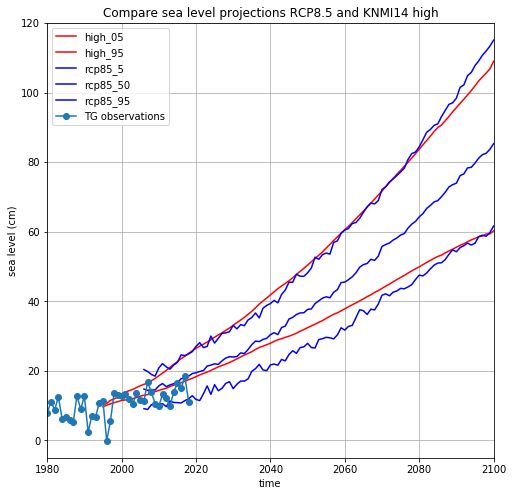

In [8]:
ref_KNMI14 = tg_df.loc[1980:2011].Average.mean()
ref_RCP = tg_df.loc[1986:2006].Average.mean()

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(KNMI14_df.iloc[:,2] + ref_KNMI14, 'r-', label=KNMI14_df.columns[2])
ax.plot(KNMI14_df.iloc[:,3] + ref_KNMI14, 'r-', label=KNMI14_df.columns[3])
ax.plot(KNMI14_85_ds.time, KNMI14_85_ds.Perc_ts[:,-1,1] + ref_RCP, 'b-', 
        label='rcp85_5')
ax.plot(KNMI14_85_ds.time, KNMI14_85_ds.Perc_ts[:,-1,3] + ref_RCP, 'b-', 
        label='rcp85_50')
ax.plot(KNMI14_85_ds.time, KNMI14_85_ds.Perc_ts[:,-1,5] + ref_RCP, 'b-', 
        label='rcp85_95')
ax.plot(tg_df['Average'], 'o-', label='TG observations')

#ax.set_aspect(1)
ax.set_xlim([1980,2100])
ax.set_ylim([-5,120])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare sea level projections RCP8.5 and KNMI14 high')
ax.grid(True)
plt.legend(loc='upper left')

plt.savefig(path_report+'CompObsKNMI14_high_RCP85.pdf', dpi=150)

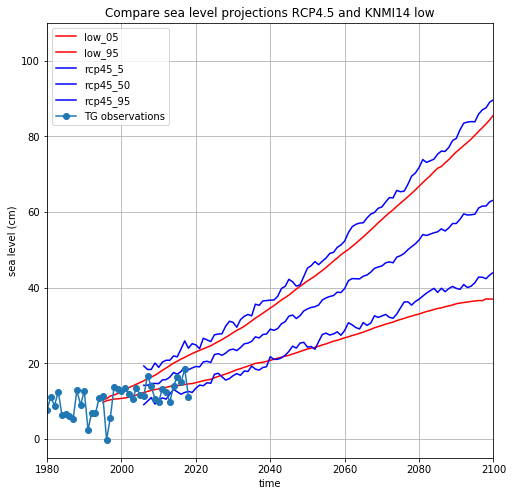

In [9]:
#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(KNMI14_df.iloc[:,0] + ref_KNMI14, 'r-', label=KNMI14_df.columns[0])
ax.plot(KNMI14_df.iloc[:,1] + ref_KNMI14, 'r-', label=KNMI14_df.columns[1])
ax.plot(KNMI14_45_ds.time, KNMI14_45_ds.Perc_ts[:,-1,1] + ref_RCP, 'b-', 
        label='rcp45_5')
ax.plot(KNMI14_45_ds.time, KNMI14_45_ds.Perc_ts[:,-1,3] + ref_RCP, 'b-', 
        label='rcp45_50')
ax.plot(KNMI14_45_ds.time, KNMI14_45_ds.Perc_ts[:,-1,5] + ref_RCP, 'b-', 
        label='rcp45_95')
ax.plot(tg_df['Average'], 'o-', label='TG observations')

#ax.set_aspect(1)
ax.set_xlim([1980,2100])
ax.set_ylim([-5,110])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare sea level projections RCP4.5 and KNMI14 low')
ax.grid(True)
plt.legend(loc='upper left')

plt.savefig(path_report+'CompObsKNMI14_low_RCP45.pdf', dpi=150)

There is a clear difference between the KNMI'14 scenarios and the original RCP based scenarios from AR5. AR5 type local projections are accelerating more. And even though they reach similar numbers in 2100 the paths are rather different.

Possile causes:
- The temperature paths are piecewise linear, this could make them less curved
- The projections have a 30 years running average

### Impact of a 30 years running average

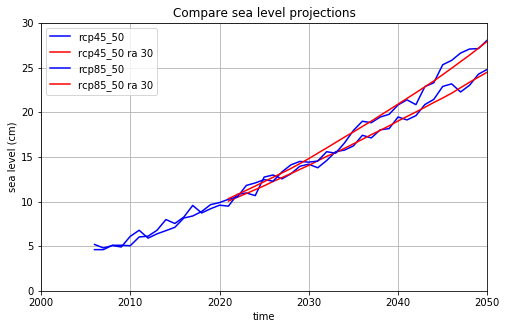

In [10]:
#Plot time series
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(KNMI14_45_ds.time, KNMI14_45_ds.Perc_ts[:,-1,3], 'b-', label='rcp45_50')
Perc_ts_ra = KNMI14_45_ds.Perc_ts.rolling(time=30, center=True).mean()
ax.plot(KNMI14_45_ds.time, Perc_ts_ra[:,-1,3], 'r-', label='rcp45_50 ra 30')

ax.plot(KNMI14_85_ds.time, KNMI14_85_ds.Perc_ts[:,-1,3], 'b-', label='rcp85_50')
Perc_ts_ra = KNMI14_85_ds.Perc_ts.rolling(time=30, center=True).mean()
ax.plot(KNMI14_85_ds.time, Perc_ts_ra[:,-1,3], 'r-', label='rcp85_50 ra 30')

ax.set_aspect(1)
ax.set_xlim([2000,2050])
ax.set_ylim([0,30])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare sea level projections')
ax.grid(True)
plt.legend(loc='upper left')

plt.savefig(path_report+'ImpactOf30yrRunningAverage.pdf', dpi=150)

This shows that applying a final 30 years running average doesn't influence the results much. But maybe applying the running average to each component before adding everything up has a bigger effect? -> To check

### Check Sybren's idea that starting the projection from a trend that uses a break point in 1993 is better than using a simple linear trend
Conclusions is that it doesn't matter much which assumption is made on the trend (linear or break point)

In [11]:
# define the statistical models
def linear_model(df, with_nodaltides=False, with_wind=False, with_ar=False):
    y = df['Average']
    X = np.c_[
        df['year']-1970, 
    ]
    month = np.mod(df['year'], 1) * 12.0
    names = ['Constant', 'Trend']
    if with_nodaltides:
        X = np.c_[
            X,
            np.cos(2*np.pi*(df['year']-1970)/18.613),
            np.sin(2*np.pi*(df['year']-1970)/18.613)
        ]
        names.extend(['Nodal U', 'Nodal V'])
    if with_wind:
        X = np.c_[
            X, 
            df['u2'],
            df['v2']
        ]
        names.extend(['Wind $u^2$', 'Wind $v^2$'])
    X = sm.add_constant(X)
    if with_ar:
        model = sm.GLSAR(y, X, missing='drop', rho=1)
    else:
        model = sm.OLS(y, X, missing='drop')
    fit = model.fit(cov_type='HC0')
    return fit, names

def broken_linear_model(df, with_nodaltides=False, with_wind=False):
    """This model fits the sea-level rise has started to rise faster in 1993."""
    y = df['Average']
    X = np.c_[
        df['year']-1970, 
        (df['year'] > 1993) * (df['year'] - 1993)
    ]
    names = ['Constant', 'Trend', '+trend (1993)']
    
    if with_nodaltides:
        X = np.c_[
            X,
            np.cos(2*np.pi*(df['year']-1970)/18.613),
            np.sin(2*np.pi*(df['year']-1970)/18.613)
        ]
        names.extend(['Nodal U', 'Nodal V'])
    
    if with_wind:
        X = np.c_[
            X, 
            df['u2'],
            df['v2']
        ]
        names.extend(['Wind $u^2$', 'Wind $v^2$'])
    X = sm.add_constant(X)
    model_broken_linear = sm.GLSAR(y, X, rho=1)
    fit = model_broken_linear.iterative_fit(cov_type='HC0')
    return fit, names

tg_df_sel = tg_df.loc[1890:].copy()
tg_df_sel['year'] = tg_df_sel.index

linear_fit, names = linear_model(tg_df_sel)
broken_linear_fit, broken_names = broken_linear_model(tg_df_sel)

tg_df_sel['linear_fit'] = linear_fit.predict()
tg_df_sel['broken_line_fit'] = broken_linear_fit.predict()

tg_df_sel.loc[2000:]

,20,22,23,24,25,32,Average,year,linear_fit,broken_line_fit
time,,,,,,,,,,
2000,11.072611,16.048387,11.313636,13.888312,10.405195,13.102721,12.638477,2000,10.419233,10.356921
2001,12.972611,17.848387,11.213636,14.788312,9.405195,13.802721,13.338477,2001,10.608158,10.609968
2002,11.272611,16.348387,10.013636,12.788312,8.005195,12.702721,11.855144,2002,10.797084,10.863014
2003,10.272611,14.148387,9.013636,10.788312,6.605195,11.802721,10.438477,2003,10.986009,11.116060
2004,13.472611,16.448387,12.213636,13.788312,11.505195,13.702721,13.521810,2004,11.174935,11.369107
2005,14.772611,15.248387,9.513636,10.288312,8.505195,12.102721,11.738477,2005,11.363860,11.622153
2006,12.172611,14.948387,9.713636,10.188312,9.205195,12.002721,11.371810,2006,11.552786,11.875200
2007,16.672611,19.848387,14.413636,17.688312,14.905195,16.802721,16.721810,2007,11.741711,12.128246
2008,13.972611,16.948387,11.913636,13.888312,12.505195,14.002721,13.871810,2008,11.930637,12.381292


In [12]:
# summary of the linear model
table = linear_fit.summary(yname='Sea-surface height', 
                           xname=names, 
                           title='Linear model (1890-current)')
IPython.display.display(table)

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Linear model (1890-current)                          
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     749.7
Date:                Fri, 27 Mar 2020   Prob (F-statistic):           4.02e-55
Time:                        15:27:38   Log-Likelihood:                -325.92
No. Observations:                 129   AIC:                             655.8
Df Residuals:                     127   BIC:                             661.6
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant       4.7515      0.302     15.747      0.000       4.160       5.343
Trend          0.1889      0.007     27.380      0.000       0.175       0.202
==============================================================================
Omnibus:                        3.628   Durbin-Watson:                   1.561
Prob(Omnibus):                  0.163   Jarque-Bera (JB):                3.220
Skew:                          -0.381   Prob(JB):                        0.200
Kurtosis:                       3.139   Cond. No.                         44.1
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [13]:
# summary of the broken linear model
print('rho=%s' % broken_linear_fit.history['rho'][-1])
IPython.display.display(broken_linear_fit.summary(yname='Sea-surface height', 
                                                  xname=broken_names))

rho=[0.20249871]


<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.779
Model:                          GLSAR   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     247.8
Date:                Fri, 27 Mar 2020   Prob (F-statistic):           3.21e-44
Time:                        15:27:38   Log-Likelihood:                -320.09
No. Observations:                 128   AIC:                             646.2
Df Residuals:                     125   BIC:                             654.7
Df Model:                           2                                         
Covariance Type:                  HC0                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant          4.4421      0.520      8.550      0.000       3.424       5.460
Trend             0.1802      0.012     14.779      0.000       0.156       0.204
+trend (1993)     0.0729      0.070      1.034      0.301      -0.065       0.211
==============================================================================
Omnibus:                        3.268   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.195   Jarque-Bera (JB):                2.744
Skew:                          -0.336   Prob(JB):                        0.254
Kurtosis:                       3.252   Cond. No.                         56.1
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

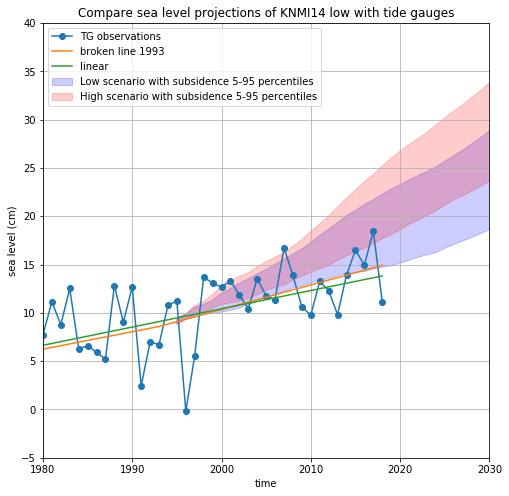

In [14]:
ref_KNMI14_blm = tg_df_sel.loc[1995]['broken_line_fit']

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.fill_between(KNMI14_df.index, KNMI14_df['low_05_sub'] + ref_KNMI14_blm, 
                KNMI14_df['low_95_sub'] + ref_KNMI14_blm, color='blue',alpha=0.2,
               label='Low scenario with subsidence 5-95 percentiles')
ax.fill_between(KNMI14_df.index, KNMI14_df['high_05_sub'] + ref_KNMI14_blm, 
                KNMI14_df['high_95_sub'] + ref_KNMI14_blm, color='red',alpha=0.2,
               label='High scenario with subsidence 5-95 percentiles')
ax.plot(tg_df['Average'], 'o-', label='TG observations')
ax.plot(tg_df_sel['year'], broken_linear_fit.predict(), label='broken line 1993')
ax.plot(tg_df_sel['year'], linear_fit.predict(), label='linear')


#ax.set_aspect(1)
ax.set_xlim([1980,2030])
ax.set_ylim([-5,40])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare sea level projections of KNMI14 low with tide gauges')
ax.grid(True)
plt.legend(loc='upper left')

plt.savefig(path_report+'BrokenLineTrend.pdf', dpi=150)

### New comparison figure between KNMI'14 and tide gauge observations

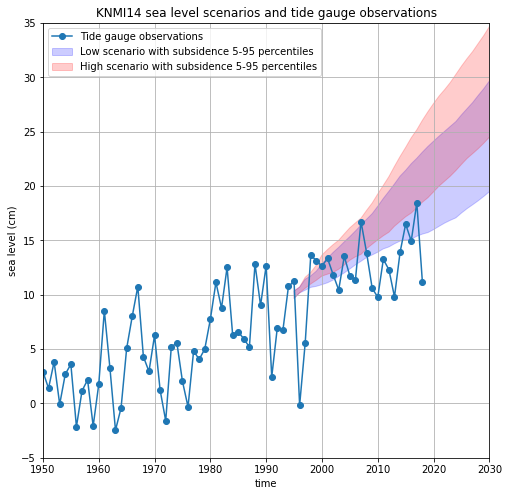

In [15]:
#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.fill_between(KNMI14_df.index, KNMI14_df['low_05_sub'] + ref_KNMI14, 
                KNMI14_df['low_95_sub'] + ref_KNMI14, color='blue',alpha=0.2,
               label='Low scenario with subsidence 5-95 percentiles')
ax.fill_between(KNMI14_df.index, KNMI14_df['high_05_sub'] + ref_KNMI14, 
                KNMI14_df['high_95_sub'] + ref_KNMI14, color='red',alpha=0.2,
               label='High scenario with subsidence 5-95 percentiles')
ax.plot(tg_df['Average'], 'o-', label='Tide gauge observations')

#ax.set_aspect(1)
ax.set_xlim([1950,2030])
ax.set_ylim([-5,35])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('KNMI14 sea level scenarios and tide gauge observations')
ax.grid(True)
plt.legend(loc='upper left')

plt.savefig(path_report+'ComparisonTG_KNMI14.pdf', dpi=150)

Add the running average of the observations

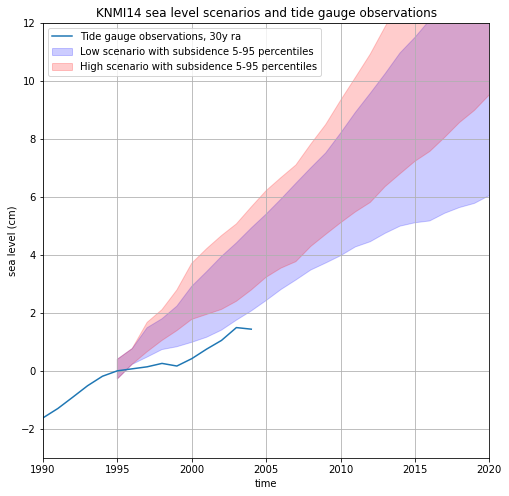

In [16]:
tg_avg_ra = tg_df['Average'].rolling(30, center=True).mean()
tg_avg_ra = tg_avg_ra - tg_avg_ra.loc[1995]

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.fill_between(KNMI14_df.index, KNMI14_df['low_05_sub'] + tg_avg_ra.loc[1995], 
                KNMI14_df['low_95_sub'] + tg_avg_ra.loc[1995], color='blue',alpha=0.2,
               label='Low scenario with subsidence 5-95 percentiles')
ax.fill_between(KNMI14_df.index, KNMI14_df['high_05_sub'] + tg_avg_ra.loc[1995], 
                KNMI14_df['high_95_sub'] + tg_avg_ra.loc[1995], color='red',alpha=0.2,
               label='High scenario with subsidence 5-95 percentiles')

ax.plot(tg_avg_ra, '-', label='Tide gauge observations, 30y ra')

#ax.set_aspect(1)
#ax.set_xlim([1950,2030])
#ax.set_ylim([-5,35])
ax.set_xlim([1990,2020])
ax.set_ylim([-3,12])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('KNMI14 sea level scenarios and tide gauge observations')
ax.grid(True)
plt.legend(loc='upper left')

plt.savefig(path_report+'RunningAverage_avg.pdf', dpi=150)

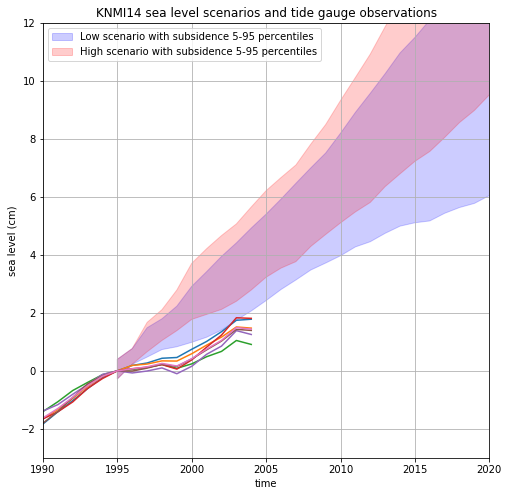

In [17]:
# Compare with individual tide gauges

tg_avg_ra = tg_df.rolling(30, center=True).mean()
tg_avg_ra = tg_avg_ra - tg_avg_ra.loc[1995]

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.fill_between(KNMI14_df.index, KNMI14_df['low_05_sub'] 
                + tg_avg_ra['Average'].loc[1995], 
                KNMI14_df['low_95_sub'] + tg_avg_ra['Average'].loc[1995], 
                color='blue',alpha=0.2,
               label='Low scenario with subsidence 5-95 percentiles')
ax.fill_between(KNMI14_df.index, KNMI14_df['high_05_sub'] 
                + tg_avg_ra['Average'].loc[1995], 
                KNMI14_df['high_95_sub'] + tg_avg_ra['Average'].loc[1995], 
                color='red',alpha=0.2,
               label='High scenario with subsidence 5-95 percentiles')

ax.plot(tg_avg_ra, '-')

#ax.set_aspect(1)
#ax.set_xlim([1950,2030])
#ax.set_ylim([-5,35])
ax.set_xlim([1990,2020])
ax.set_ylim([-3,12])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('KNMI14 sea level scenarios and tide gauge observations')
ax.grid(True)
plt.legend(loc='upper left')

plt.savefig(path_report+'RunningAverage_all.pdf', dpi=150)

This plot makes it clear that the projections are higher than the 30 years running average from the observations.

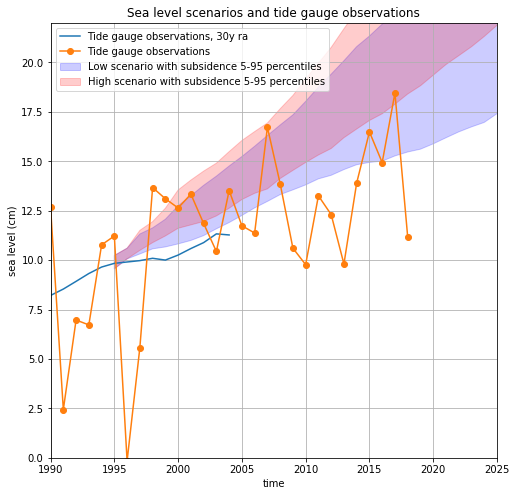

In [18]:
tg_avg_ra = tg_df['Average'].rolling(30, center=True).mean()

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.fill_between(KNMI14_df.index, KNMI14_df['low_05_sub'] + tg_avg_ra.loc[1995], 
                KNMI14_df['low_95_sub'] + tg_avg_ra.loc[1995], color='blue',alpha=0.2,
               label='Low scenario with subsidence 5-95 percentiles')
ax.fill_between(KNMI14_df.index, KNMI14_df['high_05_sub'] + tg_avg_ra.loc[1995], 
                KNMI14_df['high_95_sub'] + tg_avg_ra.loc[1995], color='red',alpha=0.2,
               label='High scenario with subsidence 5-95 percentiles')
# ax.plot(KNMI14_85_ds.time, KNMI14_85_ds.Perc_ts[:,-1,3] + ref_RCP, 'r-', 
#         label='rcp85_50')
# ax.plot(KNMI14_45_ds.time, KNMI14_45_ds.Perc_ts[:,-1,3] + ref_RCP, 'b-', 
#         label='rcp45_50')

ax.plot(tg_avg_ra, '-', label='Tide gauge observations, 30y ra')
ax.plot(tg_df['Average'], 'o-', label='Tide gauge observations')

#ax.set_aspect(1)
#ax.set_xlim([1950,2030])
#ax.set_ylim([-5,35])
ax.set_xlim([1990,2025])
ax.set_ylim([0,22])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Sea level scenarios and tide gauge observations')
ax.grid(True)
plt.legend(loc='upper left')

plt.savefig(path_report+'rcp_not_better.pdf', dpi=150)

Based on this comparison it does seem like the projections where overestimated. This makes it even more important to find out.

### Look into the components of the KNMI'14 scenarios

In [19]:
# Info on the "level" index: 
# mean, p05, p10, p50, p90, p95, last column not used.
KNMI14_high_ds = xr.open_dataset(path_KNMI14 + 
                    '/ComponentInfo/ENS_knmi_NORTHSEA_slscen_high_V8.nc', 
                                 decode_times=False)
KNMI14_low_ds = xr.open_dataset(path_KNMI14 + 
                    '/ComponentInfo/ENS_knmi_NORTHSEA_slscen_low_V8.nc', 
                                decode_times=False)
KNMI14_high_ds['time'] = KNMI14_high_ds.time + 1950
KNMI14_low_ds['time'] = KNMI14_high_ds.time + 1950
KNMI14_high_ds

<xarray.Dataset>
Dimensions:  (lat: 1, lev: 7, lon: 1, time: 115)
Coordinates:
  * time     (time) float64 1.986e+03 1.987e+03 1.988e+03 ... 2.099e+03 2.1e+03
  * lon      (lon) float64 0.0
  * lat      (lat) float64 0.0
  * lev      (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0
Data variables:
    groundw  (time, lev, lat, lon) float32 ...
    dyn_aa   (time, lev, lat, lon) float32 ...
    dyn_gre  (time, lev, lat, lon) float32 ...
    steric   (time, lev, lat, lon) float32 ...
    ibe      (time, lev, lat, lon) float32 ...
    gic      (time, lev, lat, lon) float32 ...
    smb_aa   (time, lev, lat, lon) float32 ...
    smb_gre  (time, lev, lat, lon) float32 ...
    cmip5    (time, lev, lat, lon) float32 ...
    total    (time, lev, lat, lon) float32 ...
    distr    (time, lev, lat, lon) float32 ...
    tglob    (time, lev, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Mar 

In [20]:
print(KNMI14_high_ds.total[-1,1])
print(KNMI14_high_ds.total[-1,5])
print(KNMI14_df['high_05'].iloc[-1])
print(KNMI14_df['high_95'].iloc[-1])

<xarray.DataArray 'total' (lat: 1, lon: 1)>
array([[0.495137]], dtype=float32)
Coordinates:
    time     float64 2.1e+03
  * lon      (lon) float64 0.0
  * lat      (lat) float64 0.0
    lev      float64 2.0
Attributes:
    units:    m
<xarray.DataArray 'total' (lat: 1, lon: 1)>
array([[0.974447]], dtype=float32)
Coordinates:
    time     float64 2.1e+03
  * lon      (lon) float64 0.0
  * lat      (lat) float64 0.0
    lev      float64 6.0
Attributes:
    units:    m
50.29
99.01


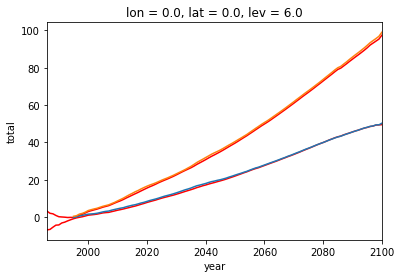

In [21]:
(KNMI14_high_ds.total[:,1]*100).plot(color='red')
(KNMI14_high_ds.total[:,5]*100).plot(color='red')
KNMI14_df['high_05'].plot()
KNMI14_df['high_95'].plot()

The total in  the budget method is not exactly the same as the csv data provided by Hylke but close enough.

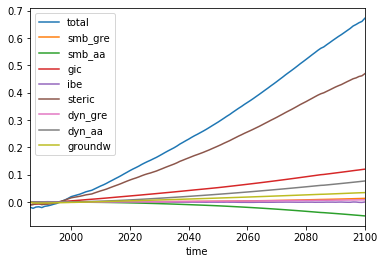

In [22]:
variables = ['total', 'smb_gre', 'smb_aa', 'gic', 'ibe', 'steric', 'dyn_gre', 
             'dyn_aa', 'groundw']

def KNMI14_ds2df(ds,level=3):
    '''Extract the time series of contributors from a sea level projection 
    xarray dataset and build a pandas dataframe. Inputs are a dataset and 
    the percentile to extract.'''
    df = pd.DataFrame()
    for idx, val in enumerate(variables):
        df[val] = ds[val][:,level,0,0]

    df['time'] = ds.time
    df = df.set_index('time')
    return df

KNMI14_high_df = KNMI14_ds2df(KNMI14_high_ds, 3)
KNMI14_high_df.plot()

### How good were the KNMI'14 projections?
Unfortunately I do not have the separation between individual contributors for these projections. I therefore focus on the comparison between the tide gauges and the AR5 type projection.

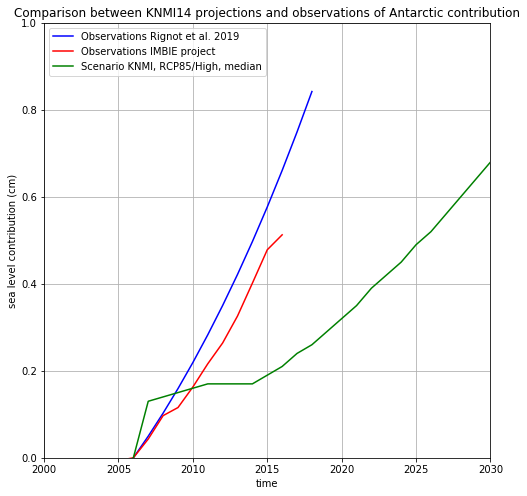

In [23]:
tg_id = [20, 22, 23, 24, 25, 32]
ant_rig_df = slc.ant_rignot19_glo() * slc.ices_fp([tg_id[0]] , 'mit_unif', 
                                              'ant') #imbie or rignot19
ant_imb_df = slc.ant_imbie_glo() * slc.ices_fp([tg_id[0]] , 'mit_unif', 
                                              'ant') #imbie or rignot19

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(ant_rig_df - ant_rig_df.loc[2006], 'b-', label='Observations Rignot et al. 2019')
ax.plot(ant_imb_df - ant_imb_df.loc[2006], 'r-', label='Observations IMBIE project')
ax.plot(KNMI14_85_ds.time, KNMI14_85_ds.Perc_ts[:,-2,3] 
        - KNMI14_85_ds.Perc_ts[0,-2,3], 'g-', 
        label='Scenario KNMI, RCP85/High, median')

ax.set_xlim([2000,2030])
ax.set_ylim([0,1])
plt.xlabel('time')
plt.ylabel('sea level contribution (cm)')
plt.title('Comparison between KNMI14 projections and '+ 
          'observations of Antarctic contribution')
ax.grid(True)
plt.legend(loc='upper left')

plt.savefig(path_report+'CompAntarcticTot_KNMI14_Obs.pdf', dpi=150)

In [24]:
# Graph of comparison between the observations and projections
# Read sea level budget for the North Sea
# Without LocSteric/GloSteric separation
#budget_df = pd.read_csv(path_slb+'SLBudget_Steric4000m_ERA5_1979_2018.csv')
# With LocSteric/GloSteric separation
budget_df = pd.read_csv(path_slb+
                        'SLBudget_Steric4000m_ERA5_1979_2018_withLocSteric.csv')
budget_df = budget_df.set_index('time')
budget_df.iloc[-10:]


,Total,LocSteric,GloSteric,GIA,Glaciers,Antarctica,Greenland,TWS,Nodal,Wind,Pressure,Obs
time,,,,,,,,,,,,
2009,5.626760,4.198394,1.861843,1.105000,0.909670,0.729029,0.108875,0.404047,-1.916751,-1.138054,-0.635294,5.600000
2010,5.448330,4.821766,2.030856,1.141833,0.943526,0.789259,0.122399,0.364924,-1.950464,-2.376886,-0.438883,4.766667
2011,8.550741,5.197153,2.161565,1.178667,0.984523,0.853186,0.137239,0.196228,-1.845019,1.992813,-2.305615,8.250000
2012,6.533385,3.131713,2.264097,1.215500,1.019514,0.920937,0.152816,0.507848,-1.612316,0.198986,-1.265710,7.300000
2013,3.981822,4.036218,2.418705,1.252333,1.046974,0.992643,0.166540,0.504573,-1.278623,-3.772410,-1.385131,4.800000
2014,7.991695,5.120443,2.510387,1.289167,1.081537,1.068433,0.173045,0.352733,-0.881605,-3.022441,0.299998,8.900000
2015,11.250551,3.969735,2.583828,1.326000,1.116099,1.148434,0.182892,0.385261,-0.466076,3.575567,-2.571189,11.483333
2016,8.155236,4.398822,2.662499,1.362833,1.150662,1.232778,0.193161,0.385261,-0.078938,-1.362074,-1.789767,9.933333
2017,14.930109,5.806969,2.758692,1.399667,1.185224,1.321592,0.205416,0.385261,0.236110,3.406622,-1.775444,13.450000


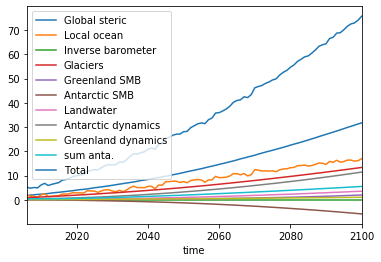

In [25]:
def ds2df(ds,perc=3):
    '''Extract the time series of contributors from a sea level projection 
    xarray dataset and build a pandas dataframe. Inputs are a dataset and 
    the percentile to extract.'''
    df = pd.DataFrame()
    for idx, val in enumerate(ds.proc):
        df[str(val.values)] = ds['Perc_ts'][:,idx,perc]

    df['time'] = ds.time
    df = df.set_index('time')
    return df
    
KNMI14_85_df = ds2df(KNMI14_85_ds)
KNMI14_45_df = ds2df(KNMI14_45_ds)
KNMI14_85_df.plot()

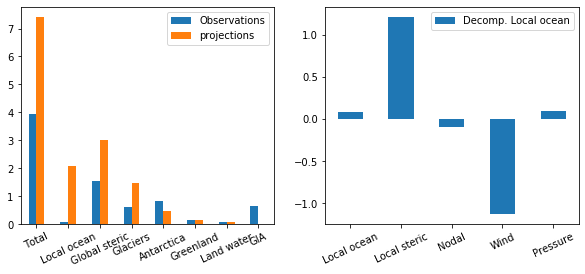

In [26]:
sp = 2010
ep = 2019
KNMI14_rcp_diff = KNMI14_85_df.loc[sp:ep].mean()

budget_diff = budget_df.loc[sp:ep].mean() - budget_df.loc[1986:2006].mean()

# Build a new dataframe for comparison purposes:
index = ['Total', 'Local ocean', 'Global steric', 'Glaciers', 'Antarctica', 
         'Greenland', 'Land water', 'GIA']
budget_LocOcean = budget_diff['LocSteric'] + budget_diff['Nodal'] \
+ budget_diff['Wind'] +  budget_diff['Pressure']
obs_budget = [budget_diff['Total'], budget_LocOcean, budget_diff['GloSteric'],
              budget_diff['Glaciers'], budget_diff['Antarctica'], 
              budget_diff['Greenland'], budget_diff['TWS'], budget_diff['GIA']]
proj = [KNMI14_rcp_diff['Total'], KNMI14_rcp_diff['Local ocean'], 
         KNMI14_rcp_diff['Global steric'], KNMI14_rcp_diff['Glaciers'],
         KNMI14_rcp_diff['sum anta.'], 
         KNMI14_rcp_diff['Greenland SMB'] + KNMI14_rcp_diff['Greenland dynamics'],
         KNMI14_rcp_diff['Landwater'],  0]
comp_df = pd.DataFrame({'Observations': obs_budget,
                   'projections': proj}, index=index)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
comp_df.plot.bar(ax=ax[0], rot=25)

index = ['Local ocean', 'Local steric', 'Nodal', 'Wind', 'Pressure']
obs_loc_ocean = [budget_LocOcean, budget_diff['LocSteric'], budget_diff['Nodal'], 
                 budget_diff['Wind'], budget_diff['Pressure']]
obs_loc_ocean_df = pd.DataFrame({'Decomp. Local ocean': obs_loc_ocean} , index=index)
obs_loc_ocean_df.plot.bar(ax=ax[1], rot=25)

plt.savefig(path_report+'Comp_KNMI14_RCP85_Obs_2010_2018.pdf', dpi=150)

It is strange that the 'Local ocean' term of the projections is so similar for the RCP45 and RCP85 scenarios.

### Removing natural variability

Let us now look at the comparison while removing some natural variability effects from the observations: wind, pressure and nodal cycle

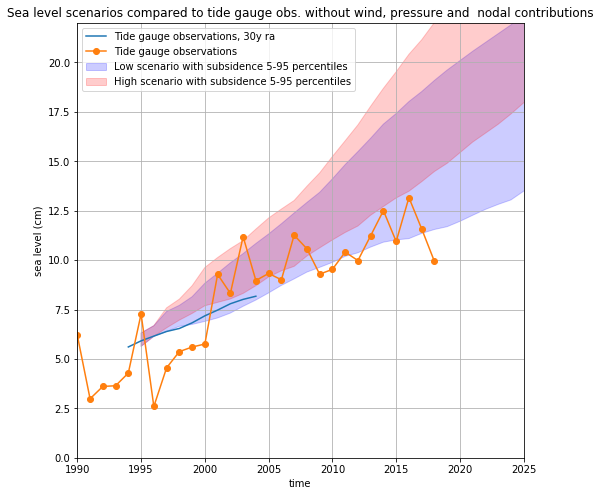

In [27]:
NatVar_df = budget_df['Wind'] + budget_df['Nodal'] + budget_df['Pressure']
tg_noNatVar_df = budget_df['Obs'] - NatVar_df
tg_avg_ra = tg_noNatVar_df.rolling(30, center=True).mean()
ref_RCP = tg_noNatVar_df.loc[1986:2006].mean()

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.fill_between(KNMI14_df.index, KNMI14_df['low_05_sub'] + tg_avg_ra.loc[1995], 
                KNMI14_df['low_95_sub'] + tg_avg_ra.loc[1995], color='blue',alpha=0.2,
               label='Low scenario with subsidence 5-95 percentiles')
ax.fill_between(KNMI14_df.index, KNMI14_df['high_05_sub'] + tg_avg_ra.loc[1995], 
                KNMI14_df['high_95_sub'] + tg_avg_ra.loc[1995], color='red',alpha=0.2,
               label='High scenario with subsidence 5-95 percentiles')
# ax.plot(KNMI14_85_ds.time, KNMI14_85_ds.Perc_ts[:,-1,3] + ref_RCP, 'r-', 
#         label='rcp85_50')
# ax.plot(KNMI14_45_ds.time, KNMI14_45_ds.Perc_ts[:,-1,3] + ref_RCP, 'b-', 
#         label='rcp45_50')

ax.plot(tg_avg_ra, '-', label='Tide gauge observations, 30y ra')
ax.plot(tg_noNatVar_df, 'o-', label='Tide gauge observations')

#ax.set_aspect(1)
#ax.set_xlim([1950,2030])
#ax.set_ylim([-5,35])
ax.set_xlim([1990,2025])
ax.set_ylim([0,22])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Sea level scenarios compared to tide gauge obs. without wind, pressure and  nodal contributions')
ax.grid(True)
plt.legend(loc='upper left')

plt.savefig(path_report+'Comp_noNatVar.pdf', dpi=150)